# 네이버 영화리뷰 감성분석 도전하기

## Step1. 데이터 준비와 확인

In [28]:
# 필요한 모듈 import 및 라이브러리 버전 확인
import os
import tensorflow as tf
import pandas as pd
import konlpy
import gensim

print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## Step 2. 데이터로더 구성
- nsmc 데이터셋은 전혀 가공되지 않은 텍스트파일로 이루어져 있으므로 가공이 필요하다.

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 데이터 중복 제거 및 NaN 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

- drop_duplicates(subset=['document'], inplace=True) : 'document'열에서 중복값을 검사해서 중복되는 행 제거한다. + 원본 변경한다.  
- tokenizer.morphs(sentence) : sentence에서 형태소 토큰화(한국어 특성상 영어의 어절 토큰화와 다르게 적용된다.)  
- np.concatenate(X_train).tolist() : X_train의 list를 합친 후 list형태로 반환

In [4]:
# 사전 index_to_word 구성
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수 
# 단, 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## Step 3. 모델 구성을 위한 데이터 분석 및 가공

In [7]:
# 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [11]:
# 적절한 최대 문장 길이 지정 및 패딩 추가
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index[""],
                                                        padding='post', 
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index[""],
                                                       padding='post', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


-------

## (1) RNN 모델

## Step 4. 모델 구성 및 validation set 구성

In [12]:
# RNN 모델 설계
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수는 16 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8)) # 가장 널리 쓰이는 RNN인 LSTM사용. LSTM state 벡터의 차원수는 8.
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [15]:
# validation set 15000건 분리
X_val = X_train[:15000]   
y_val = y_train[:15000]

# validation set을 제외한 나머지는 train set
partial_X_train = X_train[15000:]  
partial_y_train = y_train[15000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(131182, 41)
(131182,)


## Step 5. 모델 훈련 개시

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history_pre = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
257/257 [==============================] - 24s 7ms/step - loss: 0.5833 - accuracy: 0.6658 - val_loss: 0.4061 - val_accuracy: 0.8389
Epoch 2/20
257/257 [==============================] - 1s 5ms/step - loss: 0.3596 - accuracy: 0.8494 - val_loss: 0.3497 - val_accuracy: 0.8501
Epoch 3/20
257/257 [==============================] - 1s 5ms/step - loss: 0.3252 - accuracy: 0.8637 - val_loss: 0.3440 - val_accuracy: 0.8499
Epoch 4/20
257/257 [==============================] - 1s 5ms/step - loss: 0.3125 - accuracy: 0.8694 - val_loss: 0.3466 - val_accuracy: 0.8471
Epoch 5/20
257/257 [==============================] - 1s 5ms/step - loss: 0.3031 - accuracy: 0.8727 - val_loss: 0.3509 - val_accuracy: 0.8451
Epoch 6/20
257/257 [==============================] - 1s 5ms/step - loss: 0.2945 - accuracy: 0.8765 - val_loss: 0.3548 - val_accuracy: 0.8469
Epoch 7/20
257/257 [==============================] - 1s 5ms/step - loss: 0.2851 - accuracy: 0.8806 - val_loss: 0.3621 - val_accuracy: 0.8418
Epoch

In [17]:
# 테스트셋으로 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4755 - accuracy: 0.8337
[0.47545087337493896, 0.8336961269378662]


In [18]:
# train/validation loss, accuracy등이 매 epoch마다 history변수에 저장
history_dict_pre = history_pre.history
print(history_dict_pre.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## Step 6. Loss, Accuracy 그래프 시각화

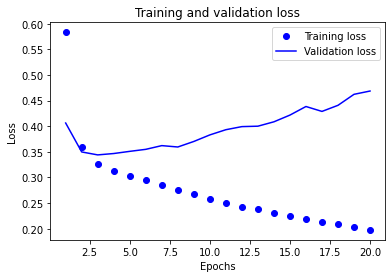

In [21]:
# loss 그래프로 그려보기
import matplotlib.pyplot as plt

loss = history_dict_pre['loss']
val_loss = history_dict_pre['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # bo는 파란색 점
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 파란색 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

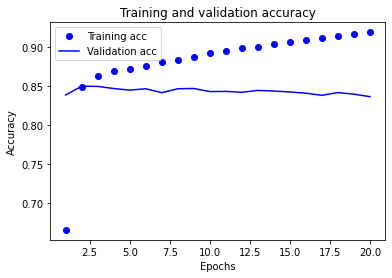

In [22]:
# accuracy 그래프로 그려보기
plt.clf() # 그림 초기화

acc = history_dict_pre['accuracy']
val_acc = history_dict_pre['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Step 7. 학습된 Embedding 레이어 분석

In [23]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) #(vocab_size, embedding_dim)

(10000, 16)


In [39]:
# 학습된 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 
 # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀 쓰기

# 단어 개수(특수문자 4개 제외)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [40]:
# Embedding 파라미터를 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['연기']
vector

array([-0.05452083, -0.00449853,  0.0152432 , -0.01739999,  0.04733285,
        0.00974153, -0.03312622, -0.02376285, -0.03638684,  0.00260602,
        0.00317988, -0.06710967, -0.00727696,  0.01759063,  0.08624219,
        0.04427349], dtype=float32)

In [41]:
# love와 유사한 단어 찾아보기
word_vectors.similar_by_word('재미')

[('아이유', 0.8895176649093628),
 ('도시', 0.8728088140487671),
 ('앞', 0.8590764403343201),
 ('해서', 0.8589829206466675),
 ('명치', 0.8585026860237122),
 ('최대한', 0.8568798899650574),
 ('로부터', 0.851660430431366),
 ('순간', 0.8495867252349854),
 ('실존', 0.8453043103218079),
 ('될지', 0.8395130038261414)]

## Step 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [44]:
# Word2Vec 모델 가져오기
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['연기']
vector

AttributeError: Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.9/site-packages/gensim/models/word2vec.py'>

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['연기']
vector  

In [ ]:
# love와 유사한 단어 찾아보기
word2vec.similar_by_word("재미")

In [ ]:
# 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]


In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 300 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()


In [ ]:
# 학습 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

In [ ]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

## Reference
[drop_duplicates](https://wikidocs.net/154060)  
[tokenizer.morphs](https://han-py.tistory.com/283)  
[np.concatenate](https://cosmosproject.tistory.com/254)  
[tolist()](https://cosmosproject.tistory.com/410)